# Machine Learning and Reinforcement Learning in Finance

**Main references**
* C.Bishop, "Pattern Recognition and Machine Learning" (2006)
* K.P Murphy, "Machine Learning: A Probabilistic Perspective" (2012)
* I. Goodfellow, Y.Bengio, and A. Courville, "Deep Learning" (2006)
* A. Geron, "Hands-On Machine Learning with Scikit-Learn and Tensorflow" (2017)

**Additional references**
* S.Marsland, "Machine Learning: An Algorithmic Perspective" (2009)
* N.Gershenfeld, "The Nature of Mathematical Modeling" (1999)
* D.Barber, "Bayesian Reasoning and Machine Learning" (2012)

## Machine Learning Landscape

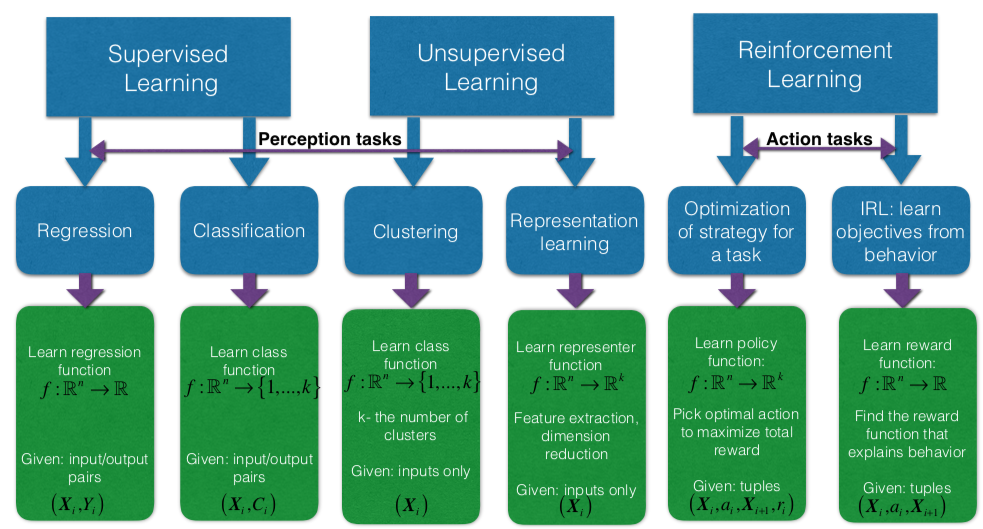

**Additional categories:**
* semi-supervised learning
* Active learning
* Sequence modeling
* RL methods for Supervisd and Unsupervised Learning

## Machine Learning in Finance

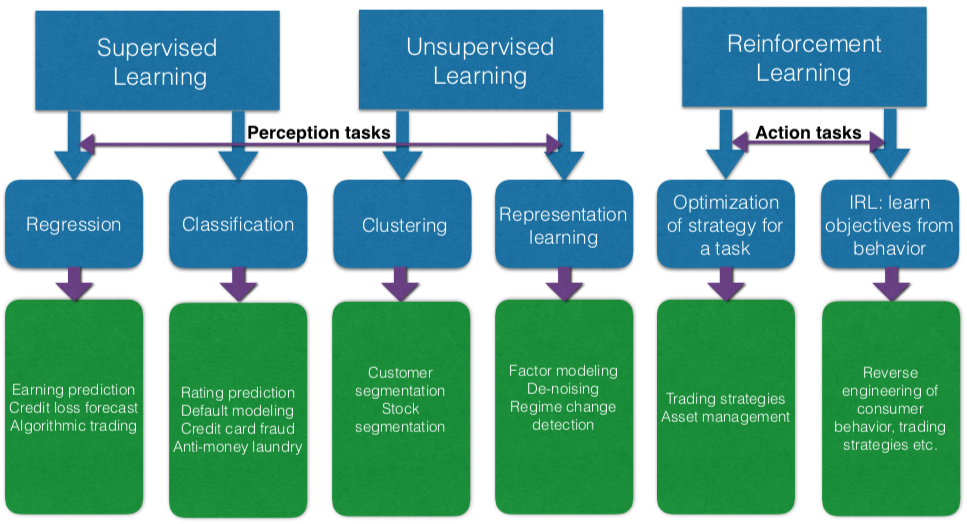

## Machine Learning by financial application areas

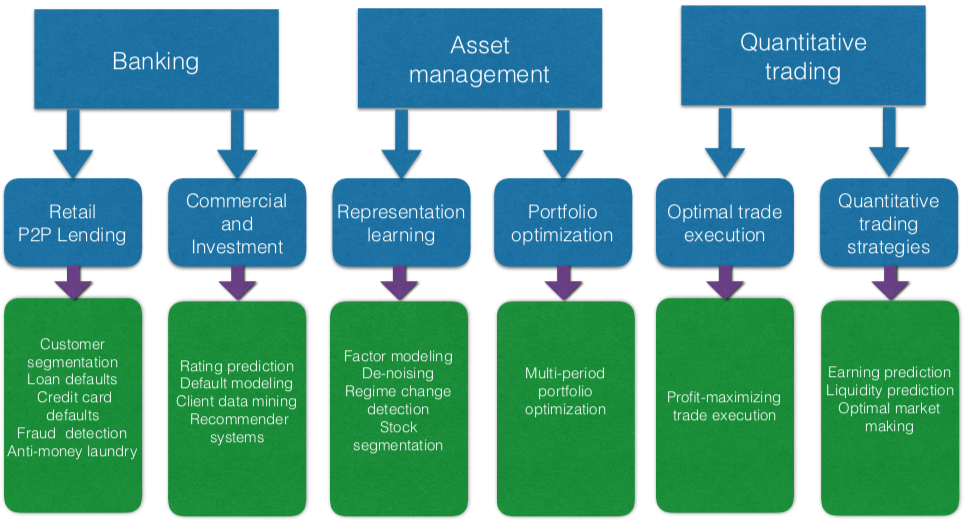

| Tasks                       | ML in Tech                                          | ML in Finance               |
|-----------------------------|-----------------------------------------------------|-----------------------------|
| Big Data?                   | typically yes                                       | typically no                |
| Stationary data?            | typically yes                                       | most often no               |
| Signal-to-noise ratio       | typically low                                       | typically high              |
| Action (RL) tasks           | Low dimensional state-action space, low uncertainty | High-dimensional state-action space, high uncertainty |
| Interpretability of results | typically, not important, or not the main focus     | Typically, either desired or required |

Regression:

R2 coefficient to determine the precision of the prediction `model.score(X, y)`

Coefficients show weights trained to fit the target `model.coef_`

intercept_  `model.intercept_`

Validation set is used to define hyper parameters on regression models

**Use cross validation** to choose hyper parameters as a better technique that can be used in smaller datasets.


## First TensorFlow demo

(Based on the Jupyter notebook 09_up_and_running_with_tensorflow.ipynb from "Hands-on Machine Learning with Scikit-Learn and TensorFlow" by A. Geron)

In [1]:
import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import time

In [2]:
# A utility function
# to make this notebook's ouput stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Creating and running a graph

In [4]:
import tensorflow as tf

In [5]:
# create variable on the default graph
reset_graph()

# variables and constants

x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
a = tf.constant(2, name='a')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# are these nodes on the graph?
print(x.graph is tf.get_default_graph())
print(y.graph is tf.get_default_graph())
print(a.graph is tf.get_default_graph())

True
True
True


In [9]:
# NOTE: we can add nodes to a specific graph, as in this example:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

# To remove duplicate or unwanted nodes:
# tf.reset_default_graph()

True
False


In [11]:
# Variables or constants are not yet initialized:
x, y, a

(<tf.Variable 'x:0' shape=() dtype=int32_ref>,
 <tf.Variable 'y:0' shape=() dtype=int32_ref>,
 <tf.Tensor 'a:0' shape=() dtype=int32>)

In [12]:
f = x*x*y + y + a

In [13]:
# lazy evaluation:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

## To evaluate the graph, we open a TensorFlow session
A TF session initializes all variables and evaluate the graph. It puts graph operations on a CPU or GPU (or a cluster), and holds all the variables values

In [14]:
# A verbose way:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
a_val = a.eval(session=sess) # a constant needs not be initiated
print('a = ', a_val)
print('result = ', result)
sess.close()

a =  2
result =  42


In [16]:
# Run a session with automatic closing at the end
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval() # the same as sess.run(f)
    a_val = a.eval()

print('a = ', a_val)
print('result = ', result)

a =  2
result =  42


## Initialization of all variables at once

In [17]:
init = tf.global_variables_initializer() # prepare an init node on the graph

with tf.Session() as sess:
    init.run() # initialize all variables
    result = f.eval()

print(result)

42


In [18]:
init

<tf.Operation 'init' type=NoOp>

## Lifecycle of a node value

In [21]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

# in this example, code evaluates w and x twice:
with tf.Session() as sess:
    print(y.eval()) # 10
    print(z.eval()) # 15

10
15


## All node values are dropped between runs, except variable values

A Variable start it life when its initializer is run, and ends it when the session is closed

In [23]:
x

<tf.Tensor 'add_4:0' shape=() dtype=int32>

## A more efficient evaluation of the TensorFlow graph

In [25]:
# in this example, the evaluation of w and x is only done once:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


## Reverse-mode autodiff in TensorFlow

Define a composite function f(w) = exp(w20 + w21 . exp(w10 + w11 . exp(w00 + w01 . x)))

In [27]:
# Implement in TF
def my_func(w,x):
    f_0 = tf.exp(w[0,0] + w[0,1] * x)   # the inner-most function
    f_1 = tf.exp(w[1,0] + w[1,1] * f_0) # the next-level function
    f_2 = tf.exp(w[2,0] + w[2,1] * f_1) # the output function
    
    return f_2, f_1, f_0

In [28]:
# A fancier implementation using name scopes:

def my_func(w,x):
    with tf.name_scope('f_0_level') as scope_0:
        f_0 = tf.exp(w[0,0] + w[0,1] * x)
    with tf.name_scope('f_1_level') as scope_1:
        f_1 = tf.exp(w[1,0] + w[1,1] * f_0)
    with tf.name_scope('f_2_level') as scope_2:
        f_2 = tf.exp(w[2,0] + w[2,1] * f_1)
    
    return f_2, f_1, f_0

In [30]:
# w_0 is a point at which we want to compute the function and its derivatives
# w_0 = np.random.rand(3,2)

w_0 = np.vstack((np.zeros(3), np.ones(3))).T

In [32]:
w_0

array([[0., 1.],
       [0., 1.],
       [0., 1.]])

## Compute gradients using TF

In [38]:
reset_graph()

#Variables and their initialization
w = tf.Variable(w_0, name='w', dtype=tf.float32)
x = tf.Variable(w_0, name='x', dtype=tf.float32, trainable=False)

# Define nodes for values of the function at layers
f_2, f_1, f_0 = my_func(w,x)

# Define nodes for the gradients by TensorFlow's autodiff
grads = tf.gradients(f_2, w)

grads

[<tf.Tensor 'gradients/AddN:0' shape=(3, 2) dtype=float32>]

In [41]:
# A Node for the initializer
init = tf.global_variables_initializer()

# Run the session

t_0 = time.time()

with tf.Session() as sess:
    sess.run(init)
    
    # function vals = sess.run([f_2, f_1, f_0])
    # gradients = sess.run(grads)
    
    gradients, function_vals = sess.run([grads, [f_2, f_1, f_0]])

print('Computed derivatives in %f3.2 sec' % (time.time() - t_0)) # 0.04 sec if done in two runs
print('Function values = ', function_vals)
print('Gradients = ', gradients)

Computed derivatives in 0.0624723.2 sec
Function values =  [array([[1.5154261e+01, 3.8142730e+06],
       [1.5154261e+01, 3.8142730e+06],
       [1.5154261e+01, 3.8142730e+06]], dtype=float32), array([[ 2.7182817, 15.154261 ],
       [ 2.7182817, 15.154261 ],
       [ 2.7182817, 15.154261 ]], dtype=float32), array([[1.       , 2.7182817],
       [1.       , 2.7182817],
       [1.       , 2.7182817]], dtype=float32)]
Gradients =  [array([[4.7137043e+08, 4.7137030e+08],
       [1.7340758e+08, 4.7137043e+08],
       [1.1442864e+07, 1.7340758e+08]], dtype=float32)]


In [42]:
my_func(w_0, x)

(<tf.Tensor 'f_2_level_1/Exp:0' shape=(3, 2) dtype=float32>,
 <tf.Tensor 'f_1_level_1/Exp:0' shape=(3, 2) dtype=float32>,
 <tf.Tensor 'f_0_level_1/Exp:0' shape=(3, 2) dtype=float32>)

In [45]:
# functionality for the graph visualization inside Juputer

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    'Strip large constant values from graph_def'
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b'<stripped %d bytes' % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    'Visualize TensorFlow graph.'
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
            function load() {{
                document.getElementById("{id}").pbtxt = {data};
            }}
        </script>
        <link rel="import" href="http://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height: 600px">
            <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))
    
    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Visualize the TensorFlow graph in the notebook

In [47]:
show_graph(tf.get_default_graph())